# Enduro setup

### Roms Download

Es posible que al generar su ambiente el código falle porque la librería *atary_py* no tiene los roms descargados.

En ese caso pueden descargar los roms ejecutando la siguiente celda.

In [1]:
# Download Roms
!wget http://www.atarimania.com/roms/Roms.rar > /dev/null
# Decompresed files
!unrar e Roms.rar > /dev/null
!unzip 'ROMS.zip' > /dev/null
# Add Roms folder to atary_py PATH
!python -m atari_py.import_roms 'ROMS' > /dev/null

# > /dev/null omits command output

--2021-06-16 21:19:20--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11128004 (11M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  10.61M   833KB/s    in 14s     

2021-06-16 21:19:34 (805 KB/s) - ‘Roms.rar’ saved [11128004/11128004]



## Gym environment

In [2]:
import gym
from gym import spaces
import cv2

def _process_frame84(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = frame[:155,10:]
    #x_t = cv2.resize(frame, (84, 84),  interpolation=cv2.INTER_LINEAR)
    x_t = cv2.resize(frame, (84, 84),interpolation=cv2.INTER_AREA)
    return x_t.astype(np.uint8)

class ProcessFrame84(gym.Wrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84))

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return _process_frame84(obs), reward, done, info

    def reset(self):
        return _process_frame84(self.env.reset())

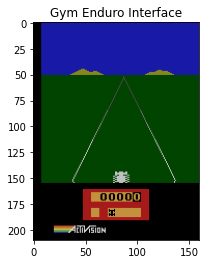

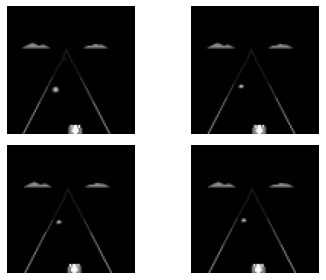

(4, 84, 84)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from gym.wrappers import AtariPreprocessing
from gym.wrappers import FrameStack

#Create environment
game = 'Enduro-v0'
env = gym.make(game,frameskip=4)

# For reproducibility
seed = 0
env.seed(seed)

obs = env.reset()

plt.imshow(np.squeeze(obs))
plt.title('Gym Enduro Interface')
plt.show()

env = ProcessFrame84(env)
env = FrameStack(env,num_stack=4)
obs = env.reset()

for _ in range(100):
  action = random.randint(0,env.action_space.n-1)
  obs, reward, done, info = env.step(action)

plt.figure()
plt.subplot(2,2,1)
plt.imshow(np.squeeze(np.array(obs)[0,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(np.squeeze(np.array(obs)[1,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,3)
plt.imshow(np.squeeze(np.array(obs)[2,:,:]),cmap='gray')
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(np.squeeze(np.array(obs)[3,:,:]),cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print(obs.shape)


In [5]:
print(env.action_space.n)

9


# Replay buffer

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = [] # Can be a list a Deque or another type of list

    def push(self, *args):
        """Saves a transition.
        e.g. ('state', 'action', 'next_state', 'reward','done')
        """

    def sample(self, batch_size):
       """ Samples a transition with a defined batch size"""

    def __len__(self):
        return len(self.memory)

# Dueling DQN Model

In [ ]:
import torch
import torch.nn as nn
import numpy as np

class Dueling_DQN(nn.Module):
    def __init__(self, in_channels, num_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = num_actions
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        self.fc1_adv = nn.Linear(in_features=7*7*64, out_features=512)
        self.fc1_val = nn.Linear(in_features=7*7*64, out_features=512)

        self.fc2_adv = nn.Linear(in_features=512, out_features=num_actions)
        self.fc2_val = nn.Linear(in_features=512, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):

        # TODO: forward pass red convolucional
        
        # TODO: forward pass rama fully-connected para V(s)
        
        # TODO: forward pass rama fully-connected para A(s,a)
        
        # TODO: Calculo de Q(s,a) a partir de ecuacion (4)

        return Q_values

# Training

Para guardar sus modelos y resultados les recomiendo montar su drive

In [ ]:
from google.colab import drive # importamos la función para montar el drive 
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import torch.optim as optim
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

replay_buffer_size=500_000
batch_size = 32
gamma = 0.99 # Discounted return
learning_starts = 50000 # Paso en que se comienza a utilizar la red para escoger acciones (siguiendo política e-greedy)
learning_freq = 4 # Frecuencia de pasos en que se ejecuta una propagación error (loss) en la red
frame_history_len = 4 # Cantidad de frames de cada estado (definido en el pre-procesamiento)
target_update_freq=10000 # Frecuencia en que se actualizan los pesos de la red target
LR = 0.00025 # Tasa de aprendizaje

in_channels = frame_history_len
input_shape = (84,84)
num_actions = env.action_space.n

# define Q target and Q 
Q = Dueling_DQN(in_channels, num_actions).to(device)
Q_target = Dueling_DQN(in_channels, num_actions).to(device)

# Optimizador, pueden elegir entre Adam o RMSProp

# Criterio de pérdida

# Creamos nuestra memoria de estados
replay_memory = ReplayMemory(replay_buffer_size)

LOG_EVERY_N_STEPS = 50_000 # (Opcional) Frecuencia en la que se muestran resultados en consola
STEPS_PER_EPOCH = 250_000 # Pasos por época
N_EPOCHS = 20 # Número de épocas

# Load checkpoint

# Reseteamos nuestro ambiente para empezar el entrenamiento
last_obs = env.reset()
for epoch in tqdm(range(N_EPOCHS),position=0,leave=True):
  for t in tqdm(range(STEPS_PER_EPOCH),position=0,leave=True):
      #1. before learning starts, choose actions randomly
      if t < learning_starts:
          action = np.random.randint(num_actions)
      else:
          # epsilon greedy exploration
          sample = random.random()
          # la funcion exploration permite calcular el threshold para la política e-greedy
          threshold = exploration(t) 
          if sample > threshold:
              with torch.no_grad():
                # Calculo de la acción con la red Q
          else:
              action = np.random.randint(num_actions)

      obs, reward, done, info = env.step(action)

      replay_memory.push(last_obs, action, obs, reward, done)
      if done:
          obs = env.reset()
          # Guardar reward acumulado del episodio

      # update last_obs
      last_obs = obs


      ### 2. Perform experience replay and train the network.
      if (t > learning_starts and t % learning_freq == 0):
          obs_t, act_t, rew_t, next_obs, done_mask = replay_memory.sample(batch_size)
          
          # Pasar los arreglos a tensores y al device actual
          # No olviden normalizar sus tensores de entrada

          # input batches to networks
          q_values = Q(obs_t)

          # Loss calculation

          # backwards pass
          optimizer.zero_grad()

          loss.backward()
          # update
          optimizer.step()

          # Actualizar pesos de red target (cada target_update_freq actualizaciones de los parámetros de Q)

    
      if t % LOG_EVERY_N_STEPS == 0:
          """
          Mostrar resultados actuales
          e.g. Mejor reward y promedio de ultimos 100 episodios
          entre otros.
          """

    """
    Guardar modelo y resultados!
    importante si se les cierra el entrenamiento
    """

# Results


Graficar promedio de últimos 100 episodios de cada época

#Testing (Opcional)

Si lo desean, pueden visualizar como su red juega enduro.
Una manera de hacerlo es guardar los *frames* de un episodio en una lista y luego visualizarlos como GIF.

Un resultado de red entrenada se puede ver a continuación

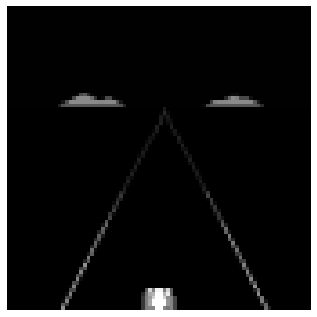

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np
from IPython.display import HTML

frames_show = frames[:300]

plt.figure(figsize=(frames_show[0].shape[1] / 15.0, frames_show[0].shape[0] / 15.0), dpi = 72)
patch = plt.imshow(frames_show[0],cmap='gray')
plt.axis('off')
animate = lambda i: patch.set_data(frames_show[i])
ani = matplotlib.animation.FuncAnimation(plt.gcf(), animate, frames=len(frames_show), interval = 100)
HTML(ani.to_jshtml())